In [879]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder



In [880]:
column_name_mapping = {
    "filename": "Track_Name",
    "length": "Duration",
    "chroma_stft_mean": "Average_Note_Intensity",
    "chroma_stft_var": "Note_Intensity_Variability",
    "rms_mean": "Loudness_Average",
    "rms_var": "Loudness_Variability",
    "spectral_centroid_mean": "Brightness_Average",
    "spectral_centroid_var": "Brightness_Variability",
    "spectral_bandwidth_mean": "Sound_Richness_Average",
    "spectral_bandwidth_var": "Sound_Richness_Variability",
    "rolloff_mean": "Bass_to_Treble_Balance_Average",
    "rolloff_var": "Bass_to_Treble_Balance_Variability",
    "zero_crossing_rate_mean": "Percussiveness_Average",
    "zero_crossing_rate_var": "Percussiveness_Variability",
    "harmony_mean": "Harmonic_Content_Average",
    "harmony_var": "Harmonic_Content_Variability",
    "perceptr_mean": "Sharpness_Average",
    "perceptr_var": "Sharpness_Variability",
    "tempo": "Tempo",
    # MFCCs grouped
    **{f"mfcc{i}_mean": f"MFCC{i}_Average" for i in range(1, 21)},
    **{f"mfcc{i}_var": f"MFCC{i}_Variability" for i in range(1, 21)},
    "label": "Genre"
}


In [881]:

# Load the dataset
path = "features_30_sec.csv/features_30_sec.csv"
data = pd.read_csv(path)

# Rename columns using predefined mapping
data_labeled = data.rename(columns=column_name_mapping)

# Drop the 'Duration' column
data_labeled = data_labeled.drop(columns="Duration")

# Check for missing values 
data_labeled.isnull().sum()

# Initialize encoders and scalers
scaler = StandardScaler()
le = LabelEncoder()

# Optionally merge rock and metal genres
# data_labeled["Genre"] = data_labeled["Genre"].replace({"rock": "rock_metal", "metal": "rock_metal"})

# Encode the Genre column
data_labeled["Genre"] = le.fit_transform(data_labeled["Genre"])

# Scale feature columns (excluding the first column and target)
data_labeled.iloc[:, 1:-1] = scaler.fit_transform(data_labeled.iloc[:, 1:-1])

# Separate features and target
X = data_labeled.iloc[:, 1:-1]  # Fixed slicing
y = data_labeled["Genre"]

y

0      0
1      0
2      0
3      0
4      0
      ..
995    9
996    9
997    9
998    9
999    9
Name: Genre, Length: 1000, dtype: int32

In [882]:
genre_mapping = {index: label for index, label in enumerate(le.classes_)}
print("Encoded Labels:", genre_mapping)

Encoded Labels: {0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}


In [883]:
print("Data Shape:", X.shape)
print("Data Labels Shape:", y.shape)
print(X.describe())

Data Shape: (1000, 57)
Data Labels Shape: (1000,)
       Average_Note_Intensity  Note_Intensity_Variability  Loudness_Average  \
count            1.000000e+03                1.000000e+03      1.000000e+03   
mean            -4.831691e-16               -1.882938e-15     -4.973799e-16   
std              1.000500e+00                1.000500e+00      1.000500e+00   
min             -2.531623e+00               -5.404508e+00     -1.913980e+00   
25%             -7.239436e-01               -5.228113e-01     -6.743707e-01   
50%              5.469008e-02                3.554380e-02     -1.292693e-01   
75%              7.011661e-01                6.358062e-01      6.816804e-01   
max              3.489945e+00                2.815991e+00      4.067671e+00   

       Loudness_Variability  Brightness_Average  Brightness_Variability  \
count          1.000000e+03        1.000000e+03            1.000000e+03   
mean          -9.947598e-17        1.563194e-16            9.947598e-17   
std          

Uncomment the code below to see the charts of the data distribution

In [884]:
# num_features = X.select_dtypes(include=['number']).columns

# # Set up figure size
# plt.figure(figsize=(20, 30))

# # Plot each feature's distribution
# for i, feature in enumerate(num_features):
#     plt.subplot(10, 6, i + 1)  # Adjust subplot grid if needed
#     sns.histplot(X[feature], bins=30, kde=True)
#     plt.title(f"Distribution of {feature}")

# # Show the plots
# plt.tight_layout()
# plt.show()

Capping outliers had a negative effect on the model

In [885]:

# lower_percentile = X.iloc[:, :].quantile(0.01)
# upper_percentile = X.iloc[:, :].quantile(0.99)

# X_capped = X.iloc[:, 1:].clip(lower=lower_percentile, upper=upper_percentile, axis=1)


In [886]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

In [887]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [888]:
X.dtypes

Average_Note_Intensity                float64
Note_Intensity_Variability            float64
Loudness_Average                      float64
Loudness_Variability                  float64
Brightness_Average                    float64
Brightness_Variability                float64
Sound_Richness_Average                float64
Sound_Richness_Variability            float64
Bass_to_Treble_Balance_Average        float64
Bass_to_Treble_Balance_Variability    float64
Percussiveness_Average                float64
Percussiveness_Variability            float64
Harmonic_Content_Average              float64
Harmonic_Content_Variability          float64
Sharpness_Average                     float64
Sharpness_Variability                 float64
Tempo                                 float64
MFCC1_Average                         float64
MFCC1_Variability                     float64
MFCC2_Average                         float64
MFCC2_Variability                     float64
MFCC3_Average                     

In [889]:
X_prepared = torch.tensor(X.values, dtype=torch.float32).to(device)
y_prepared = torch.tensor(y.values, dtype=torch.long).to(device)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_prepared, 
                                                    y_prepared, 
                                                    test_size=0.2,
                                                    random_state=52
)

X_train[:2], y_train[:5]

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [890]:
X.shape[1]

57

In [891]:
# Creating Datasets for mini-batch training

from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

Defining the structure of the NN

In [892]:
class MusicGenreClassifier(nn.Module):
    def __init__(self, input_size, num_classes, hidden_size=70):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size*2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size*2, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, hidden_size//2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size//2, num_classes)
        )

    def forward(self, x):
        return self.net(x)
    
model_music = MusicGenreClassifier(input_size=57, num_classes=len(genre_mapping)).to(device)
model_music

MusicGenreClassifier(
  (net): Sequential(
    (0): Linear(in_features=57, out_features=140, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=140, out_features=70, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=70, out_features=35, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=35, out_features=10, bias=True)
  )
)

Setting uo the loss and optimizer with the l2 regularization

In [893]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_music.parameters(), lr=0.001, weight_decay=0.0001)

In [894]:
torch.manual_seed(52)

epochs = 20000

best_loss = float("inf")
patience = 200
epochs_no_improve = 0

for epoch in range(epochs):   

    model_music.train()

    for batch_X, batch_y in train_loader:
        y_pred = model_music(batch_X)
        loss= loss_fn(y_pred, batch_y)

        accuracy = (y_pred.argmax(1) == batch_y).float().mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model_music.eval()
    with torch.inference_mode():
        y_test_pred = model_music(X_test)
        test_loss = loss_fn(y_test_pred, y_test)
        test_accuracy = (y_test_pred.argmax(1) == y_test).float().mean()

    if test_loss < best_loss:
        best_loss = test_loss
        epochs_no_improve = 0
        # (Optional) Save the best model weights here
        # torch.save(model_music.state_dict(), "best_model.pth")
    else:
        epochs_no_improve += 1

    if epoch % 10 == 0:
        print(f"Epoch {epoch} => Loss: {loss:.4f}, Accuracy: {accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    if epochs_no_improve >= patience:
        print(f"Early stopping on epoch {epoch}")
        break


Epoch 0 => Loss: 2.1395, Accuracy: 0.2500, Test Loss: 2.1298, Test Accuracy: 0.4000
Epoch 10 => Loss: 0.9353, Accuracy: 0.6250, Test Loss: 0.9712, Test Accuracy: 0.6300
Epoch 20 => Loss: 0.6061, Accuracy: 0.7500, Test Loss: 0.9698, Test Accuracy: 0.6300
Epoch 30 => Loss: 0.5660, Accuracy: 0.7500, Test Loss: 1.0372, Test Accuracy: 0.6800
Epoch 40 => Loss: 0.3834, Accuracy: 0.8750, Test Loss: 1.0212, Test Accuracy: 0.6750
Epoch 50 => Loss: 0.3587, Accuracy: 0.8750, Test Loss: 1.0313, Test Accuracy: 0.7050
Epoch 60 => Loss: 0.1073, Accuracy: 0.9375, Test Loss: 1.0832, Test Accuracy: 0.6950
Epoch 70 => Loss: 0.3509, Accuracy: 0.9375, Test Loss: 1.2356, Test Accuracy: 0.6900
Epoch 80 => Loss: 0.2062, Accuracy: 0.9375, Test Loss: 1.2231, Test Accuracy: 0.7100
Epoch 90 => Loss: 0.0716, Accuracy: 0.9375, Test Loss: 1.3020, Test Accuracy: 0.6800
Epoch 100 => Loss: 0.0326, Accuracy: 1.0000, Test Loss: 1.2671, Test Accuracy: 0.7000
Epoch 110 => Loss: 0.7505, Accuracy: 0.8750, Test Loss: 1.4428, T

In [895]:
model_music.eval()
with torch.inference_mode():
    y_test_pred_logits = model_music(X_test)  # shape: [num_test_samples, num_classes]
    y_test_pred_labels = y_test_pred_logits.argmax(dim=1)


In [896]:
from sklearn.metrics import confusion_matrix

# Convert tensors to CPU & NumPy if you're on GPU
# (If you're already on CPU, you can skip .cpu())
y_test_np = y_test.cpu().numpy()
y_test_pred_np = y_test_pred_labels.cpu().numpy()

# Create the confusion matrix
cm = confusion_matrix(y_test_np, y_test_pred_np)
print("Confusion Matrix:\n", cm)


Confusion Matrix:
 [[13  1  0  0  0  3  1  1  1  0]
 [ 0 14  0  0  0  6  0  0  0  0]
 [ 1  1 16  0  0  1  0  0  1  3]
 [ 0  0  1 10  2  0  2  1  0  4]
 [ 1  0  0  0 15  0  1  0  4  0]
 [ 0  1  0  0  0 14  0  0  0  0]
 [ 2  0  0  0  1  0 20  0  1  1]
 [ 0  0  0  1  0  0  0 14  2  0]
 [ 1  0  0  1  1  0  0  1 15  3]
 [ 3  0  1  1  0  1  1  0  1  9]]


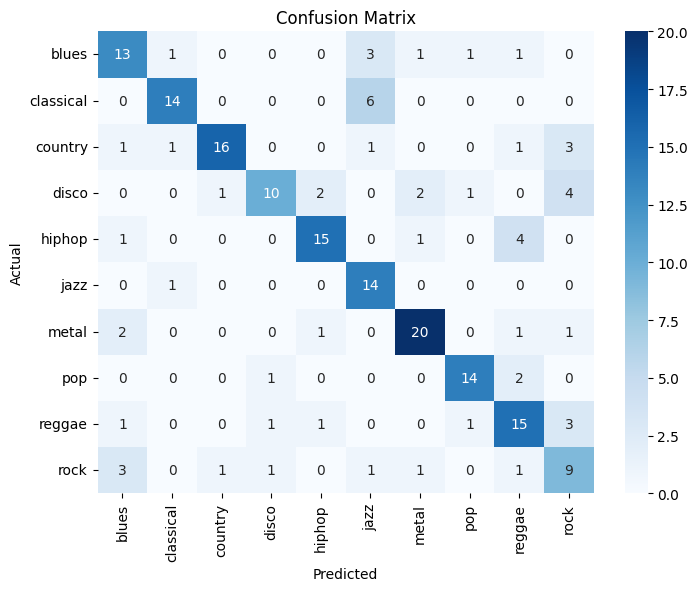

In [897]:
# Suppose you have a dictionary mapping like:
# genre_mapping = {0: 'blues', 1: 'classical', ...}
labels = list(genre_mapping.values())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


After trying to teach the model with the different structure (activation functions, number and the structure of the hidden layers), regularization weights, learning rate, batch sizes, etc. I have achieved the predictions of 71% on the test set with a strong overfit.   